In [1]:
from coffea.nanoevents import BaseSchema, NanoEventsFactory
import dask_awkward as dak
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import hist
import mplhep as hep
import numba
import vector
vector.register_awkward()

In [2]:
events = NanoEventsFactory.from_root(
    file="../data/p8_ee_ZH_ecm240/events_101027117.root:events",
    schemaclass=BaseSchema,
    # schemaclass=DelphesSchema, Doesn't work 
    # schemaclass=NanoAODSchema.v7, Doesn't work
    metadata={
        "path":"/eos/experiment/fcc/ee/generation/DelphesEvents/spring2021/IDEA/p8_ee_ZH_ecm240/events_101027117.root",
        "name":"p8_ee_ZH_ecm240",
        "process":"ZH to mumu, ecm=240 GeV"
    }
).events()

In [3]:
events.fields

['Electron',
 'Electron#0',
 'Electron#0/Electron#0.index',
 'Electron#0/Electron#0.collectionID',
 'Muon',
 'Muon#0',
 'Muon#0/Muon#0.index',
 'Muon#0/Muon#0.collectionID',
 'AllMuon',
 'AllMuon#0',
 'AllMuon#0/AllMuon#0.index',
 'AllMuon#0/AllMuon#0.collectionID',
 'EFlowNeutralHadron',
 'EFlowNeutralHadron/EFlowNeutralHadron.type',
 'EFlowNeutralHadron/EFlowNeutralHadron.energy',
 'EFlowNeutralHadron/EFlowNeutralHadron.energyError',
 'EFlowNeutralHadron/EFlowNeutralHadron.position.x',
 'EFlowNeutralHadron/EFlowNeutralHadron.position.y',
 'EFlowNeutralHadron/EFlowNeutralHadron.position.z',
 'EFlowNeutralHadron/EFlowNeutralHadron.positionError[6]',
 'EFlowNeutralHadron/EFlowNeutralHadron.iTheta',
 'EFlowNeutralHadron/EFlowNeutralHadron.phi',
 'EFlowNeutralHadron/EFlowNeutralHadron.directionError.x',
 'EFlowNeutralHadron/EFlowNeutralHadron.directionError.y',
 'EFlowNeutralHadron/EFlowNeutralHadron.directionError.z',
 'EFlowNeutralHadron/EFlowNeutralHadron.shapeParameters_begin',
 'EFlo

In [4]:
mu_0_index = events['Muon#0/Muon#0.index'].compute()

In [5]:
Recon = events['ReconstructedParticles/ReconstructedParticles.energy'].compute()

In [6]:
useful_events = events[ak.num(Recon) > 0]

In [7]:
useful_events['ReconstructedParticles/ReconstructedParticles.energy'].compute()

<Array [[0.388, 1.19, ..., 2.9, 1.22], ...] type='99984 * [var * float32[pa...'>

In [8]:
Reco_E = useful_events['ReconstructedParticles/ReconstructedParticles.energy'].compute()
Reco_px = useful_events['ReconstructedParticles/ReconstructedParticles.momentum.x'].compute()
Reco_py = useful_events['ReconstructedParticles/ReconstructedParticles.momentum.y'].compute()
Reco_pz = useful_events['ReconstructedParticles/ReconstructedParticles.momentum.z'].compute()
Muon_index = useful_events['Muon#0/Muon#0.index'].compute()

In [9]:
Reco_E[:,[0]]

<Array [[0.388], [0.305], ..., [0.539], [30.6]] type='99984 * 1 * float32[p...'>

In [10]:
def index_mask(input_array, index_array):
    if len(input_array) != len(index_array) :
        raise Exception('Length of Input_array and index_array does not match!')
    counts = len(ak.count(input_array, axis = 1))
    @numba.jit
    def numba_wrap(input_array, index_array,counts):
        output_array = []
        for event_index in range(counts):
            event_mask = index_array[event_index]
            reco_list = input_array[event_index]
            output_array.append([reco_list[i] for i in  event_mask])
        return output_array
    return ak.Array(numba_wrap(input_array,index_array,counts))

In [11]:
Muon_E = index_mask(Reco_E, Muon_index)
Muon_px = index_mask(Reco_px, Muon_index)
Muon_py = index_mask(Reco_py, Muon_index)
Muon_pz = index_mask(Reco_pz, Muon_index)

In [12]:
Muon_E[ak.num(Muon_E)>0]

<Array [[43.4], [61.6, 41.5], ..., [29.8], [36.6]] type='11229 * var * float64'>

In [13]:
import hist

In [14]:
mu_px = hist.Hist.new.Reg(100,0,200).Double().fill(ak.flatten(Muon_px))
mu_py = hist.Hist.new.Reg(100,0,200).Double().fill(ak.flatten(Muon_py))
mu_pz = hist.Hist.new.Reg(100,0,200).Double().fill(ak.flatten(Muon_pz))

In [15]:
from coffea.analysis_tools import PackedSelection

In [61]:
sel = PackedSelection()
sel.add('px > 10', ak.all(Muon_px > 10,axis=-1))
sel.add('px > 20', ak.all(Muon_px > 20,axis=-1))
sel.add('px > 30', ak.all(Muon_px > 30,axis=-1))
sel.add('px > 40', ak.all(Muon_px > 40,axis=-1))
sel.add('px > 50', ak.all(Muon_px > 50,axis=-1))

In [53]:
c = sel.cutflow('px > 10','px > 20','px > 30','px > 40','px > 50')

In [54]:
cutflow = c.yieldhist()

In [55]:
onecut_hist, cutflow_hist, labels = cutflow

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fb4041efaa0>, errorbar=None, legend_artist=None)]

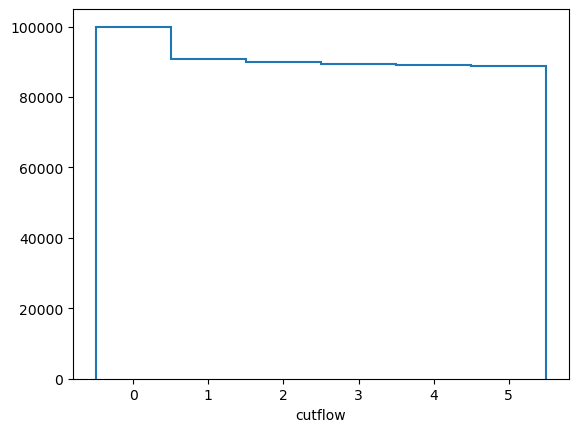

In [56]:
cutflow_hist.plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fb403a6e660>, errorbar=None, legend_artist=None)]

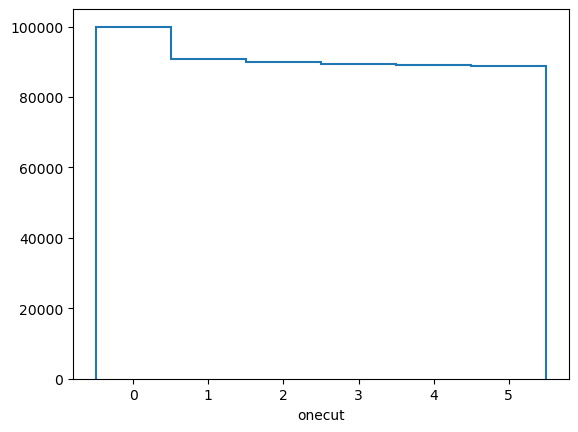

In [57]:
onecut_hist.plot()

In [58]:
labels

['initial', 'px > 10', 'px > 20', 'px > 30', 'px > 40', 'px > 50']